## Описание проекта

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.
У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

В вашем распоряжении три датасета. 

Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, 
`orders_info_short.csv` — информацию о покупках, 
а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`

`User Id` — уникальный идентификатор пользователя,

`Region` — страна пользователя,

`Device` — тип устройства пользователя,

`Channel` — идентификатор источника перехода,

`Session Start` — дата и время начала сессии,

`Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`

`User Id` — уникальный идентификатор пользователя,

`Event Dt` — дата и время покупки,

`Revenue` — сумма заказа.

Структура `costs_info_short.csv`

`Channel` — идентификатор рекламного источника,

`Dt` — дата проведения рекламной кампании,

`Costs` — расходы на эту кампанию.

## Шаг 1. Загрузите данные и подготовьте их к анализу ##
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import warnings

warnings.simplefilter('ignore')


vizits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

display(vizits.head(5))
display(orders.head(5))
costs.head(5)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Приведем название столбцов к общему формату. Необходимо сделать переименование колонок.

In [2]:
vizits.rename(columns={'User Id':'user_id', 
                      'Region':'region', 
                      'Device':'device', 
                      'Channel':'channel', 
                      'Session Start':'session_start',
                      'Session End':'session_end'}, 
                    inplace=True)
orders.rename(columns={'User Id':'user_id', 
                       'Event Dt':'event_dt',
                       'Revenue':'revenue'},
                    inplace=True)
costs.rename(columns={'Channel':'channel'}, inplace=True)

Ознакомились с данными. В таблицах присутствует данные содержащие информацию о времени. Так как мы будем работать со временем, преобразуем данные в формат времени

In [3]:
vizits['session_start'] = pd.to_datetime(vizits['session_start'])
vizits['session_end'] = pd.to_datetime(vizits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

## Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии. ##


In [4]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    
 # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 
    
    
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 



In [5]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 
    
    


In [6]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [7]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Проведите исследовательский анализ данных. ##

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [8]:
profiles = get_profiles(vizits, orders, costs)
display(profiles.head(5))
# минимальную и максимальную дату привлечения пользователей.
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
display(f'Минимальная {min_date} и максимальная {max_date} дата соответственно')

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


'Минимальная 2019-05-01 и максимальная 2019-10-27 дата соответственно'

### Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей? ###

,Пользователи,Платящие пользователи,Процент
region,,,
France,17450,663.0,3.80
Germany,14981,616.0,4.11
UK,17575,700.0,3.98
United States,100002,6902.0,6.90


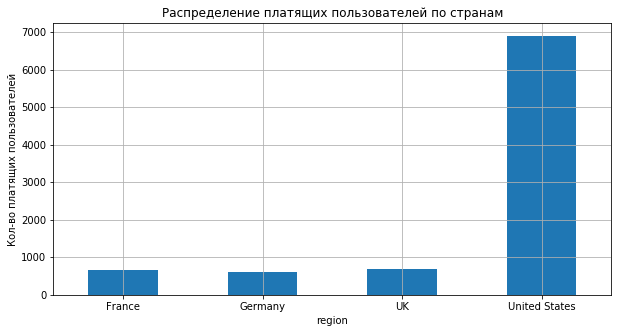

In [9]:
profiles_group = profiles.groupby('region').agg({'user_id':'nunique', 'payer':'sum'})
profiles_group['percent'] = round(profiles_group['payer'] / profiles_group['user_id'] * 100, 2)
profiles_group.columns = ['Пользователи', 'Платящие пользователи', 'Процент']
display(profiles_group)        
profiles.groupby('region').agg({'payer':'sum'}).plot(kind = 'bar', 
                                                     grid=True, 
                                                     legend=False, 
                                                     figsize=(10,5),
                                                    )
        
plt.title('Распределение платящих пользователей по странам')
plt.xticks(rotation=0)
plt.ylabel('Кол-во платящих пользователей')
plt.show()

**Вывод** Приложением Procrastinate Pro+ распространяется в следующих странах: Франция, Германия, Англия, США. Последняя приносит больше всего платящих пользователей.

### Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

,Пользователи,Платящие пользователи,Процент
device,,,
Mac,30042,1912.0,6.36
PC,30455,1537.0,5.05
Android,35032,2050.0,5.85
iPhone,54479,3382.0,6.21


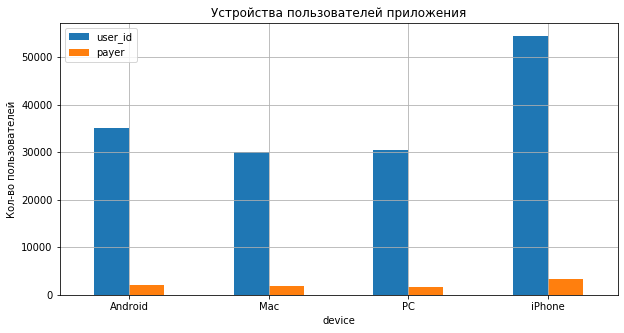

In [10]:
profiles_group = profiles.groupby('device').agg({'user_id':'nunique', 'payer':'sum'}).sort_values(by='user_id')
profiles_group['percent'] = round(profiles_group['payer'] / profiles_group['user_id'] * 100, 2)
profiles_group.columns = ['Пользователи', 'Платящие пользователи', 'Процент']
display(profiles_group)  
profiles.groupby('device').agg({'user_id':'count', 'payer':'sum'}).plot(kind = 'bar',
                                                                       grid=True,
                                                                       legend=True,
                                                                       figsize=(10,5))
plt.title('Устройства пользователей приложения')
plt.xticks(rotation=0)
plt.ylabel('Кол-во пользователей')
plt.show()

**Вывод:**  Данное приложение распространяется на 4-ёх устройствах (`PC`,`Mac`,`Android`,`iPhone`). Чаще всего используют `iPhone`, что не удивительно если приложение чаще всего используют в Америке. И соотвтественно чаще всего оплачивают подписку пользователи `iPhone`

### По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

,Пользователи,Платящие пользователи,Процент
channel,,,
lambdaMediaAds,2149,225.0,10.47
AdNonSense,3880,440.0,11.34
YRabbit,4312,165.0,3.83
MediaTornado,4364,156.0,3.57
RocketSuperAds,4448,352.0,7.91
LeapBob,8553,262.0,3.06
WahooNetBanner,8553,453.0,5.30
OppleCreativeMedia,8605,233.0,2.71
TipTop,19561,1878.0,9.60


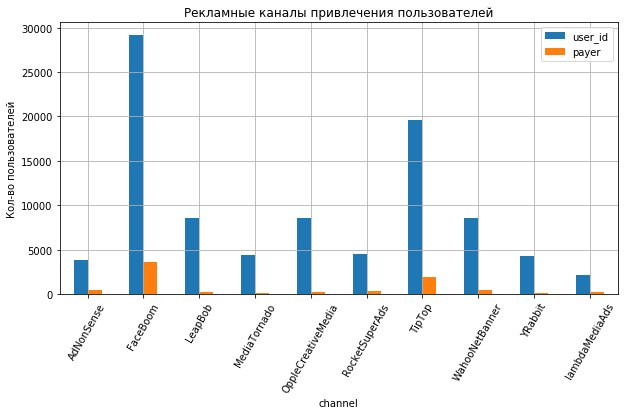

In [11]:
profiles_group = profiles.groupby('channel').agg({'user_id':'nunique', 'payer':'sum', }).sort_values(by='user_id')
profiles_group['percent'] = round(profiles_group['payer'] / profiles_group['user_id'] * 100, 2)
profiles_group.columns = ['Пользователи', 'Платящие пользователи', 'Процент']
display(profiles_group)  
# для визуализации уберем данные по источнику organic. Данный источник нельзя отнести  к рекламным каналам
profiles.query('channel != "organic"').groupby('channel').agg({'user_id':'count', 'payer':'sum'}).plot(kind = 'bar',
                                                                       grid=True,
                                                                       legend=True,
                                                                       figsize=(10,5))
plt.title('Рекламные каналы привлечения пользователей')
plt.xticks(rotation=60)
plt.ylabel('Кол-во пользователей')
plt.show()

**Вывод** наибольшее число пользователей приносит `органика`. Это пользователи на привлечение которых не было напрямую затрачены деньги. (Условно бесплатный канал).Наибольшее число пользовтаетелй приходят с `FaceBoom` и `TipTop`. С них же соотвтественно приходят и больше пользователей которые оформляют подписку. Стоит обратить внимание на каналы `AdNonSense` `lambdaMediaAds` при небольшом общем числе пользователей этот канал дает значительное число оформивших подписку

## Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Так как в дальнейшем нас интересуют только пользователи за привлечение которых компания заплатила, исключим из расчетов пользователей которые зашли через поисковик, рекомендации друзей, бесплатные ссылки и т.д. (категория organic)

In [12]:
profiles = profiles.query('channel != "organic"')

In [13]:
display(f'Суммарные затраты на рекламу составили {round(profiles["acquisition_cost"].sum(),2)}')
profiles_group = profiles.pivot_table(index='channel', 
                                      values='acquisition_cost', 
                                      aggfunc='sum').sort_values(by='acquisition_cost')
profiles_group

'Суммарные затраты на рекламу составили 105497.3'

,acquisition_cost
channel,
YRabbit,944.22
MediaTornado,954.48
lambdaMediaAds,1557.60
LeapBob,1797.60
RocketSuperAds,1833.00
OppleCreativeMedia,2151.25
AdNonSense,3911.25
WahooNetBanner,5151.00
FaceBoom,32445.60


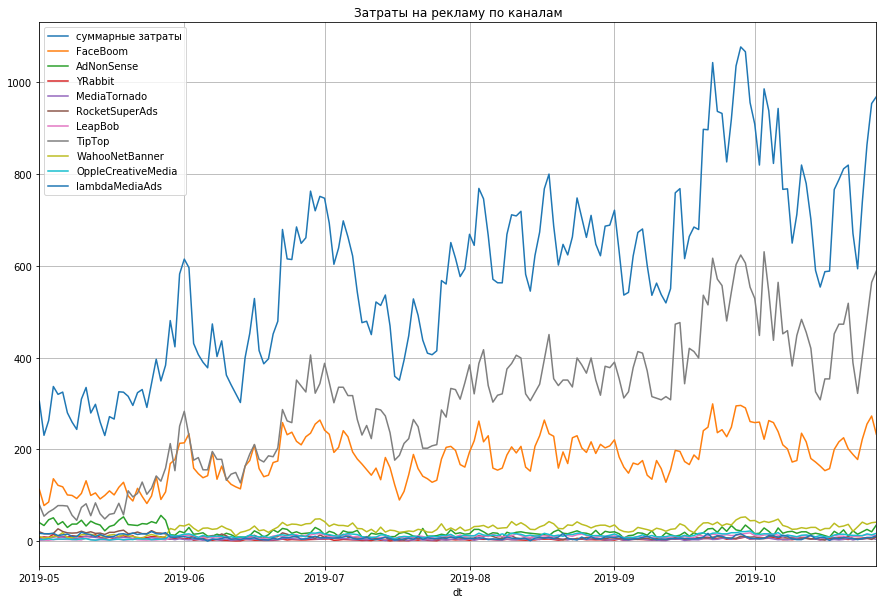

In [14]:
profiles_group = profiles.pivot_table(index='dt', 
                                      values='acquisition_cost', 
                                      aggfunc='sum')
for i in profiles['channel'].unique():
    profiles_group[i] = profiles.query('channel == @i').pivot_table(index=['dt'], 
                                      values='acquisition_cost', 
                                      aggfunc='sum')
profiles_group.rename(columns={'acquisition_cost':'суммарные затраты'}, inplace=True)
profiles_group.plot(grid=True,
                    legend=True,
                    figsize=(15,10))
plt.title('Затраты на рекламу по каналам')
plt.show()

**Выводы** В период с мая по октябрь затраты на рекламу увеличивались, при этом основной поток средств шел в канал `TipTop`. Затраты на канал `FaceBoom` с июня находятся примерно на одном уровне. Затртаты на остальные каналы составляют незначительную долю и на протяжении 6 месяцев значительно не меняются.

## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

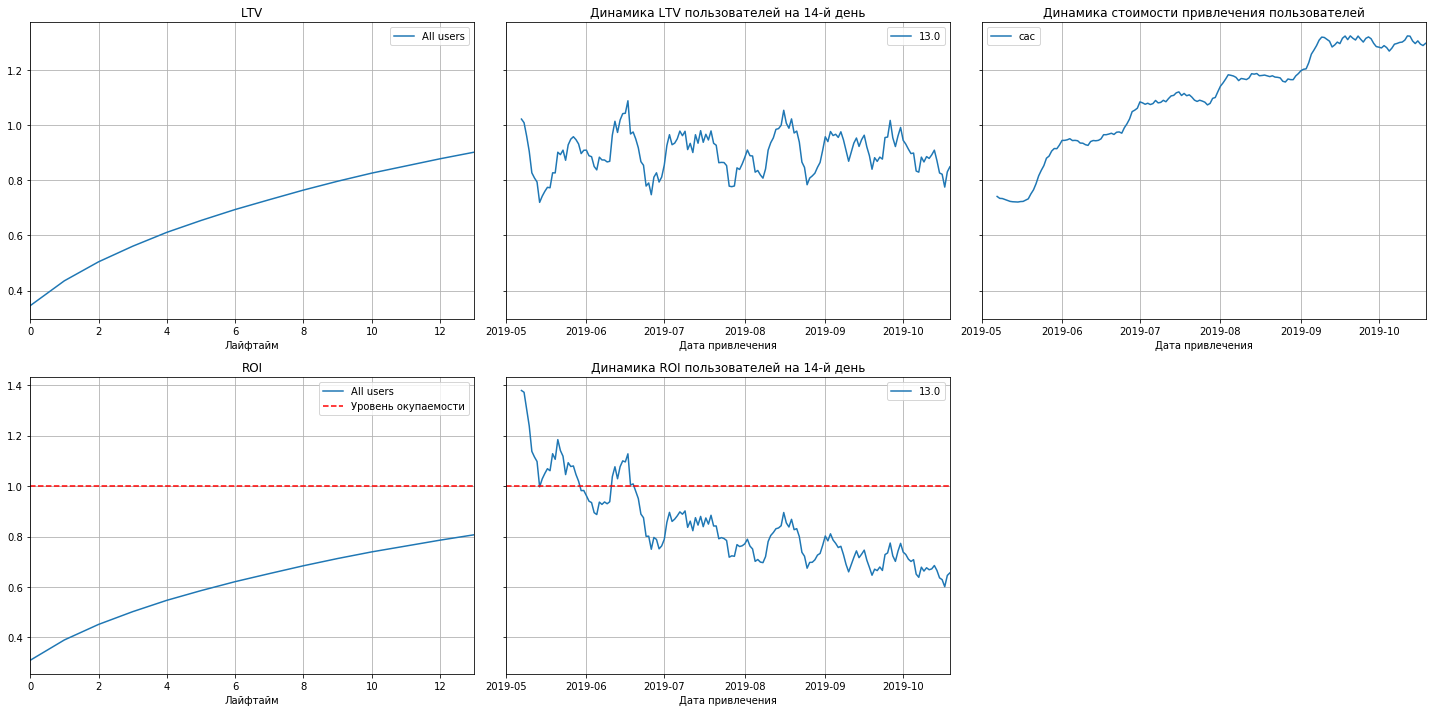

In [15]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Выводы:** По графикам можно сделать следующие выводы
- реклама не окупается. На конец 2-ой неделе кривая ROI (возврат на инвестиции) почти достигает уровня 1, но не пересекает его, что говорит об убыточности рекламной компании
- стоимость привлечения пользователей растет, следовательно увеличивается бюджет рекламной компании в течении 6 месяцев или уменьшению размер когорт (пользователей)
- ROI на протяжении 6 месяцев планомерно снижается

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

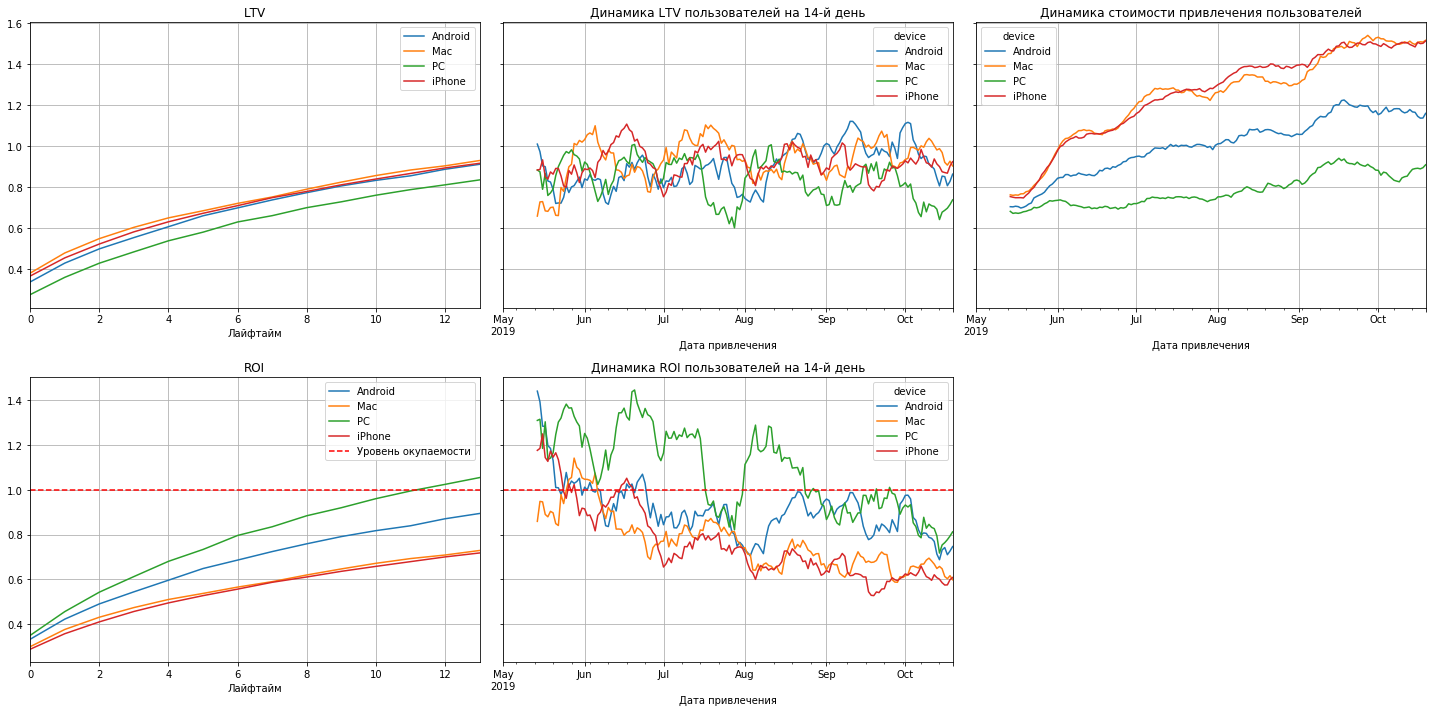

In [16]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Выводы:** По графикам можно сделать следующие выводы
- графики всех устройств ведут себя приблизительно одинаково. Следовательно можно предположить что проблема низкого ROI не связанна с устройтсвами, и приложение работает одинаково хорошо на всех устройствах
- пользователи устройств на `PC` более охоно оформляют подписку. ROI на этих устройствах пересекает уровень окупаемости

### Проанализируйте окупаемость рекламы с разбивкой по странам

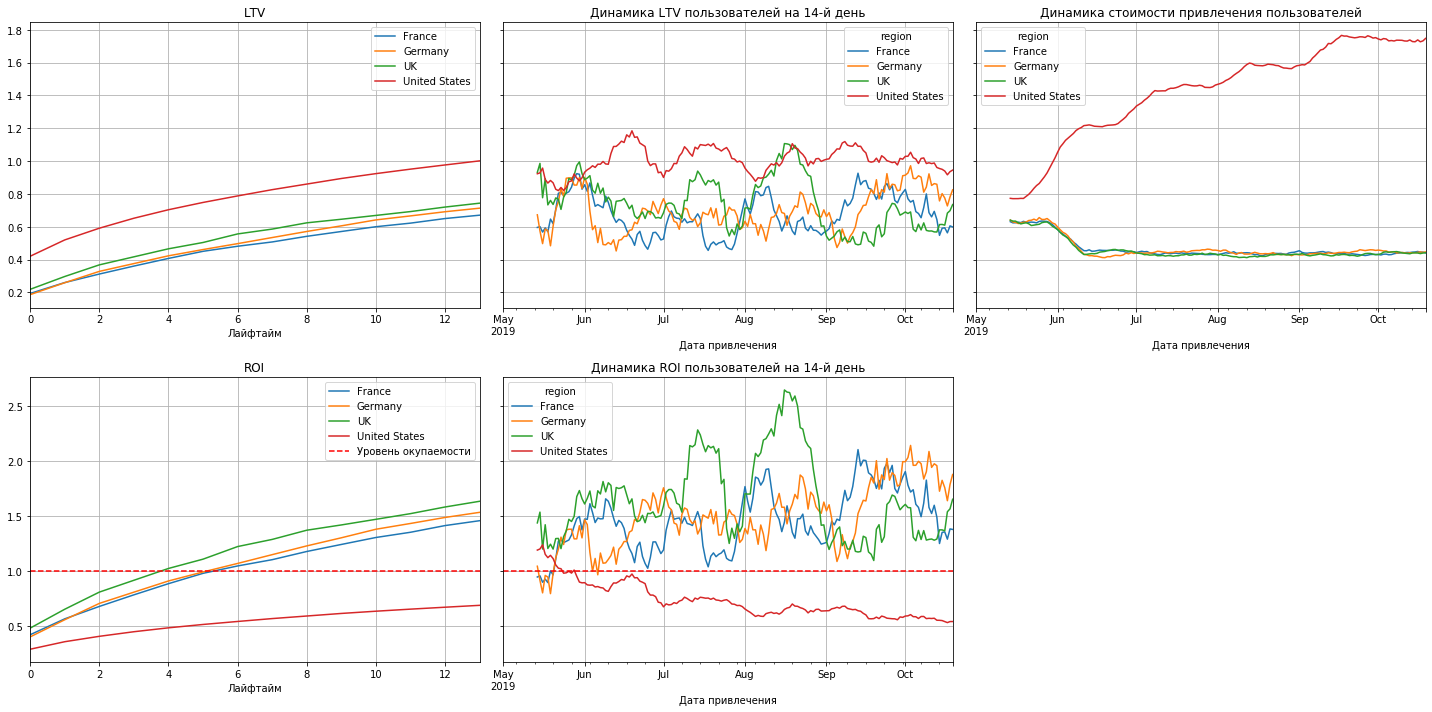

In [17]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод** Серия этих графиков показывает нам основную проблемму низкой окупаемости рекламной компании
- реклама в США находится ниже порога окупаемости
- рост динамики привлечения пользователей в США говорит нам либо об увеличении затрат на рекламу в регионе либо о резком падении интереса к приложению в США (уменьшение размеров когорт)
- все остальные регионы (кроме США) показывают стабильную положительную динамику на всех приведенных графиках

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

Т.к. в предыдущем пункте была выявлен регион, оказывающий негативную динамику на окупаемость рекламной компании, в этом пункте будем исследовать данные только по США

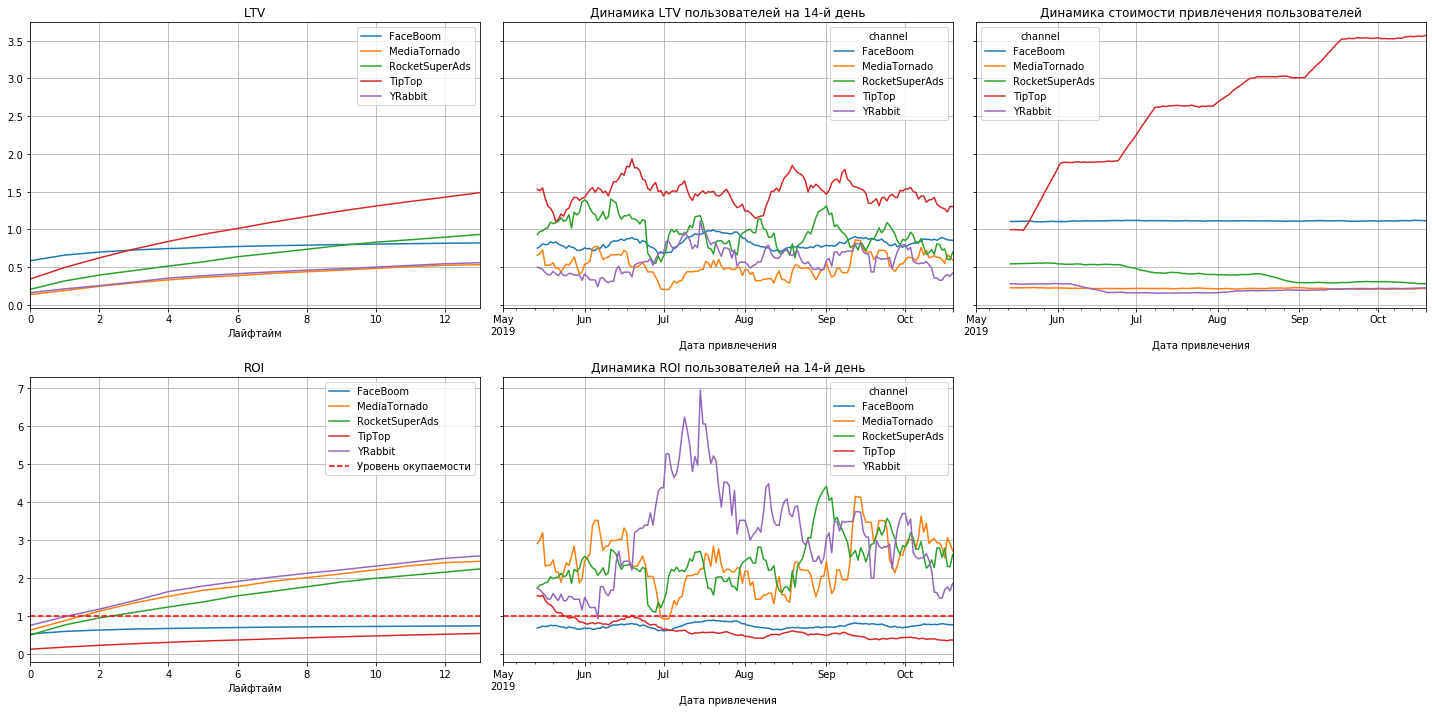

In [18]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

profiles_usa = profiles.query('region == "United States"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод** По графикам можно сделать вывод:
- большинство источников трафика окупаются, за исключением `FaceBoom` и `TipTop`
- динамика стоимости привлечения по каналу `TipTop` показывает аномальный рост.

## Выводы
Произведя анализ показателей рекламной компании приложения Procrastinate Pro+, можно говорить о неэффективности рекламной компании за последние 6 месяцев.За 2 недели ROI составляет около 80%, а для окупаемости показатель ROI должен быть больше 100%. При этом наблюдается постоянный рост стоимости привлечения одного пользователя. Углубившись в изучение метрик, была выявлена проблемма. Реклама в США дает нам самую негативную динамику. И только по этой стране наблюдается такой аномальный рост CAC (стоимости привлечения одного пользователя). По другим странам, в которых пользуются приложением Procrastinate Pro+, наблюдается стабильно положительная динамика ROI.

Проанализировав окупаемость рекламы с разбивкой по рекламным каналам в США, был вывлен "источник всех бед" - рекламная компания на `TipTop`. Только на этой площадке наблюдается аномальный рост CAC и очень низкий показатель ROI (чуть больше 50%). Так же отрицательную динамику показывает канал `FaceBoom`, но его окупаемость намного ближе к 100% чем у `TipTop`.

Рекомендации отделу маркетинга: 
1) Обратить внимание на рекламный канал `TipTop` и постоянное увеличение CAC. Это можно обьяснить 2-я фаторами. Либо увеличение затрат на рекламу. Маркетологи видя значительный рост количества пользователей начинают "вливать" больше денег в канал. Либо значительное падение размер кагорт(количество пользователей). Очень похоже что реклама идет по модели оплаты за показы (Cost Per Mille). При такой модели рекламы трафик значительно растет, но он очень низкого качества. Приложение скачивает много пользователей которые совсем не заинтересованны в нем. Так же в пользу этой гипотезы говорит ступенчатое увеличение CAC (приблизительно конец-начало месяца) - время пополнение бюджета рекламной площадки (это только гипотеза)

2) Настроить таргетинг по каналам `TipTop` и `FaceBoom`. Это повысит качество трафика. Уменьшится количество пользователей, которые не готовы оформить подписку.

3) Рассмотреть ситуацию на рынке в США. Перенастроить рекламную компанию - сделать ее более таргетированной. Рассмотреть внешние фактроы, возможно в США есть похожее приложение которое больше подходит американцам.

4) Так же можно просто отключить показы  на территории США. Такое действие также выправит ситуацию по ROI, правда в долгосрочной перспективе окажет негативную тенденцию на количество пользователей с канала `organic`